# 01 — Exploratory Data Analysis (EPL 2019‑2025)

This notebook loads the **processed** dataset created by the ETL pipeline (`data/processed/merged.parquet`) and provides a concise exploratory overview:

1. Shape & schema  
2. Descriptive statistics  
3. Goal distributions (home vs away)  
4. Expected-goals (xG) distributions (home vs away)  
5. xG vs actual goal difference scatter  
6. Bookmaker implied probabilities (describe + calibration)  
7. Class balance for match outcome target  
8. Correlation heat-map (numeric features)  
9. Season-by-season analysis (average goals & xG + rolling trends)  
10. Team-level over/under-performance (home)   
11. Team-level aggregates per league (horizontal bars)  
12. Final summary: all teams (horizontal bar home goals vs xG)  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 120


df = pd.read_parquet("../data/processed/merged.parquet", engine="fastparquet")


if "season" not in df.columns:
    df["season"] = df["date"].dt.year

In [3]:
display(df.head())
print("Shape:", df.shape)
df.info(show_counts=True)

,date,league,home_team,away_team,home_goals,away_goals,bookie_home,bookie_draw,bookie_away,xG_home,xG_away,bookie_sum,bookie_prob_home,bookie_prob_draw,bookie_prob_away,result,season
0,2024-08-16,EPL,Man United,Fulham,1,0,1.60,4.20,5.25,2.042680,0.418711,1.053571,0.593220,0.225989,0.180791,H,2024
1,2024-08-17,EPL,Ipswich,Liverpool,0,2,8.50,5.50,1.33,0.342601,3.929060,1.051345,0.111901,0.172939,0.715160,A,2024
2,2024-08-17,EPL,Arsenal,Wolves,2,0,1.18,7.50,13.00,1.628300,0.575835,1.057714,0.801216,0.126058,0.072726,H,2024
3,2024-08-17,EPL,Everton,Brighton,0,3,2.63,3.30,2.63,0.405325,1.790830,1.063487,0.357530,0.284940,0.357530,A,2024
4,2024-08-17,EPL,Newcastle,Southampton,1,0,1.36,5.25,8.00,0.433489,1.954830,1.050770,0.699767,0.181273,0.118960,H,2024


Shape: (10707, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10707 entries, 0 to 10706
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              10707 non-null  datetime64[ns]
 1   league            10707 non-null  object        
 2   home_team         10707 non-null  object        
 3   away_team         10707 non-null  object        
 4   home_goals        10707 non-null  int64         
 5   away_goals        10707 non-null  int64         
 6   bookie_home       10702 non-null  float64       
 7   bookie_draw       10702 non-null  float64       
 8   bookie_away       10702 non-null  float64       
 9   xG_home           10707 non-null  float64       
 10  xG_away           10707 non-null  float64       
 11  bookie_sum        10702 non-null  float64       
 12  bookie_prob_home  10702 non-null  float64       
 13  bookie_prob_draw  10702 non-null  float64       
 14  boo

In [4]:
display(df.describe().T)

cat_cols = df.select_dtypes(include=["object", "category"]).columns
for col in cat_cols:
    print(f"\nColumn `{col}` unique count: {df[col].nunique()}")
    display(df[col].value_counts().head(10))

,count,mean,min,25%,50%,75%,max,std
date,10707,2022-07-11 04:05:02.605771776,2019-08-09 00:00:00,2021-01-29 00:00:00,2022-05-21 00:00:00,2023-12-26 00:00:00,2025-05-25 00:00:00,NaN
home_goals,10707.0,1.536004,0.0,1.0,1.0,2.0,9.0,1.303076
away_goals,10707.0,1.277108,0.0,0.0,1.0,2.0,9.0,1.174994
bookie_home,10702.0,2.766802,1.05,1.67,2.25,3.1,23.0,1.793908
bookie_draw,10702.0,4.056016,2.0,3.4,3.6,4.33,17.0,1.199253
bookie_away,10702.0,4.281353,1.07,2.25,3.25,5.0,34.0,3.267367
xG_home,10707.0,1.593626,0.0,0.892988,1.43661,2.129595,6.88189,0.935313
xG_away,10707.0,1.298788,0.0,0.675299,1.14988,1.743595,6.49734,0.832272
bookie_sum,10702.0,1.054627,1.027616,1.050813,1.053974,1.057714,1.166667,0.006293
bookie_prob_home,10702.0,0.436933,0.041212,0.302799,0.423077,0.568224,0.907318,0.181807



Column `league` unique count: 5


league
EPL           2280
LALIGA        2280
SERIEA        2280
LIGUE1        2031
BUNDESLIGA    1836
Name: count, dtype: int64


Column `home_team` unique count: 137


home_team
Man United        114
Arsenal           114
Everton           114
Newcastle         114
West Ham          114
Chelsea           114
Tottenham         114
Crystal Palace    114
Brighton          114
Real Madrid       114
Name: count, dtype: int64


Column `away_team` unique count: 137


away_team
Liverpool         114
Man City          114
Wolves            114
Brighton          114
Aston Villa       114
Crystal Palace    114
West Ham          114
Man United        114
Tottenham         114
Osasuna           114
Name: count, dtype: int64


Column `result` unique count: 3


result
H    4596
A    3411
D    2700
Name: count, dtype: int64

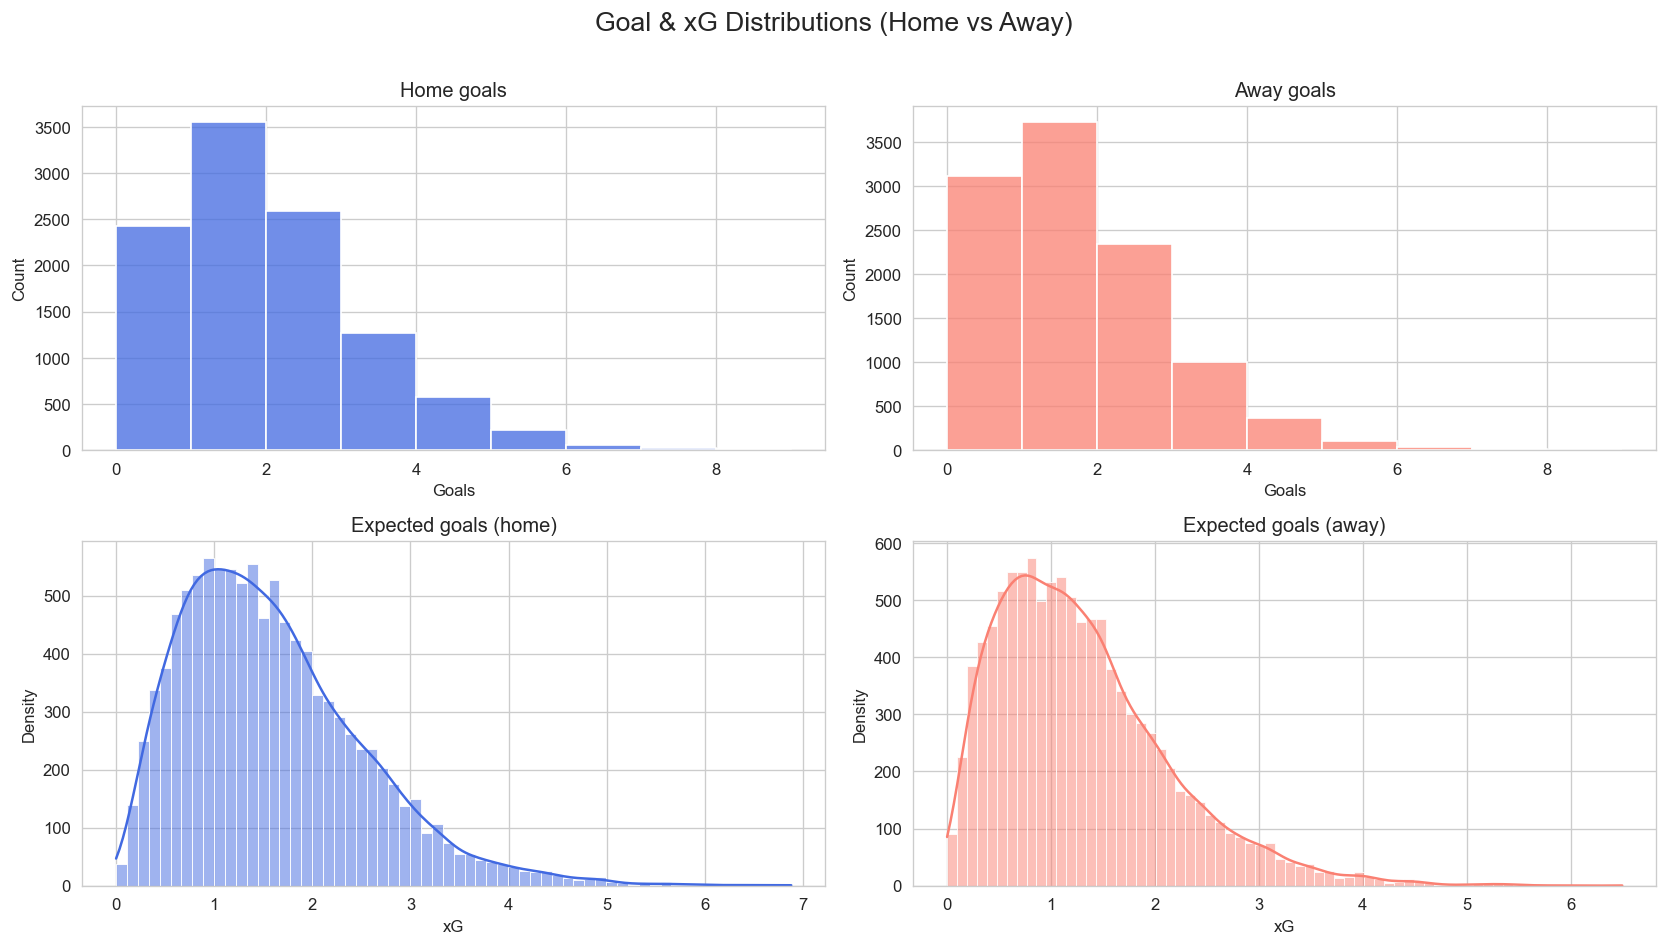

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

sns.histplot(df["home_goals"], bins=range(0, 10), ax=axes[0,0], color="royalblue")
axes[0,0].set(title="Home goals", xlabel="Goals", ylabel="Count")

sns.histplot(df["away_goals"], bins=range(0, 10), ax=axes[0,1], color="salmon")
axes[0,1].set(title="Away goals", xlabel="Goals", ylabel="Count")

sns.histplot(df["xG_home"], kde=True, ax=axes[1,0], color="royalblue")
axes[1,0].set(title="Expected goals (home)", xlabel="xG", ylabel="Density")

sns.histplot(df["xG_away"], kde=True, ax=axes[1,1], color="salmon")
axes[1,1].set(title="Expected goals (away)", xlabel="xG", ylabel="Density")

plt.suptitle("Goal & xG Distributions (Home vs Away)", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.97])
plt.show()

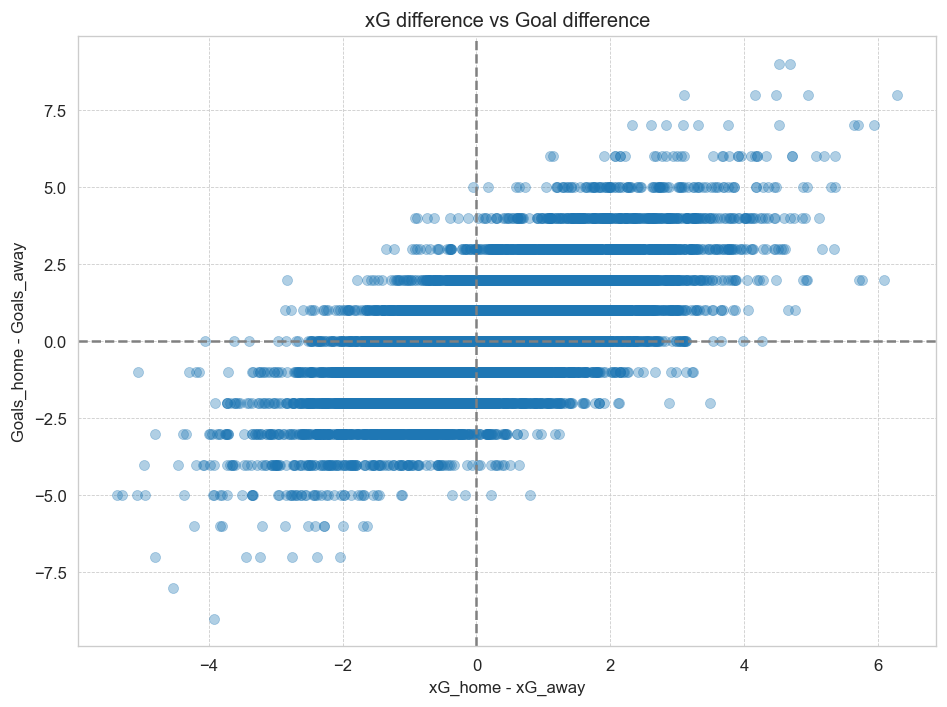

In [6]:
df["xg_diff"]   = df["xG_home"]   - df["xG_away"]
df["goal_diff"] = df["home_goals"] - df["away_goals"]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="xg_diff", y="goal_diff", alpha=0.35, edgecolor=None)
plt.axhline(0, ls="--", c="grey")
plt.axvline(0, ls="--", c="grey")
plt.title("xG difference vs Goal difference")
plt.xlabel("xG_home - xG_away")
plt.ylabel("Goals_home - Goals_away")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

,count,mean,std,min,25%,50%,75%,max
bookie_prob_home,10702.0,0.436933,0.181807,0.041212,0.302799,0.423077,0.568224,0.907318
bookie_prob_draw,10702.0,0.247006,0.048164,0.056031,0.221964,0.260229,0.279829,0.448204
bookie_prob_away,10702.0,0.316061,0.165687,0.027781,0.189383,0.290390,0.419355,0.885873


C:\Users\barte\AppData\Local\Temp\ipykernel_4316\955420885.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(bins)


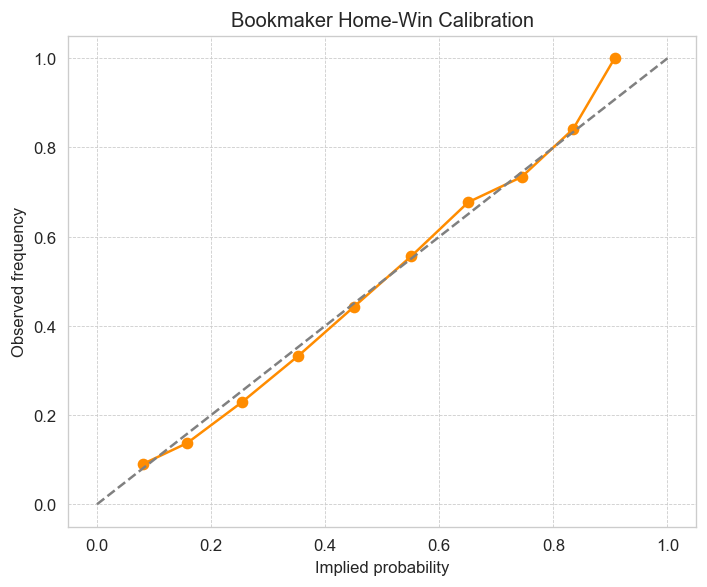

,predicted,actual,count
bookie_prob_home,,,
"(0.0, 0.1]",0.081448,0.090909,132
"(0.1, 0.2]",0.158068,0.137275,998
"(0.2, 0.3]",0.254377,0.229316,1535
"(0.3, 0.4]",0.352441,0.332393,2127
"(0.4, 0.5]",0.449991,0.442405,2179
"(0.5, 0.6]",0.550844,0.556194,1566
"(0.6, 0.7]",0.650970,0.677473,1203
"(0.7, 0.8]",0.744321,0.733918,684
"(0.8, 0.9]",0.834476,0.841155,277


In [7]:
df["bookie_sum"] = 1/df["bookie_home"] + 1/df["bookie_draw"] + 1/df["bookie_away"]
df["bookie_prob_home"] = (1/df["bookie_home"]) / df["bookie_sum"]
df["bookie_prob_draw"] = (1/df["bookie_draw"]) / df["bookie_sum"]
df["bookie_prob_away"] = (1/df["bookie_away"]) / df["bookie_sum"]

display(df[["bookie_prob_home","bookie_prob_draw","bookie_prob_away"]].describe().T)

bins = pd.cut(df["bookie_prob_home"], np.linspace(0,1,11))
calibration = (df
    .groupby(bins)
    .agg(predicted=("bookie_prob_home","mean"),
         actual   =("result", lambda x: (x=="H").mean()),
         count    =("result","size"))
    .dropna())

plt.figure(figsize=(6,5))
plt.plot(calibration["predicted"], calibration["actual"], "o-", color="darkorange")
plt.plot([0,1],[0,1], "--", color="grey")
plt.title("Bookmaker Home-Win Calibration")
plt.xlabel("Implied probability")
plt.ylabel("Observed frequency")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

display(calibration)

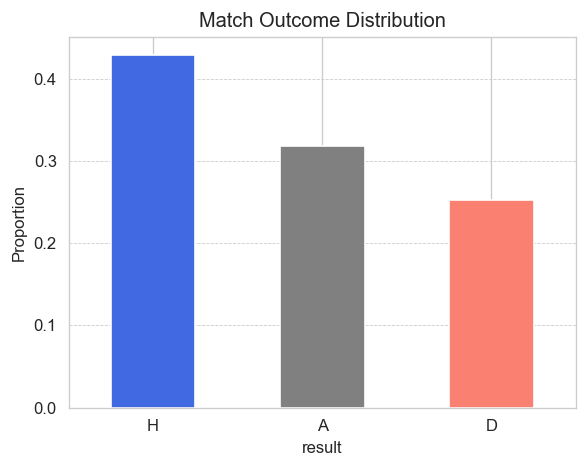

In [8]:
plt.figure(figsize=(5,4))
df["result"].value_counts(normalize=True).plot.bar(color=["royalblue","grey","salmon"])
plt.title("Match Outcome Distribution")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

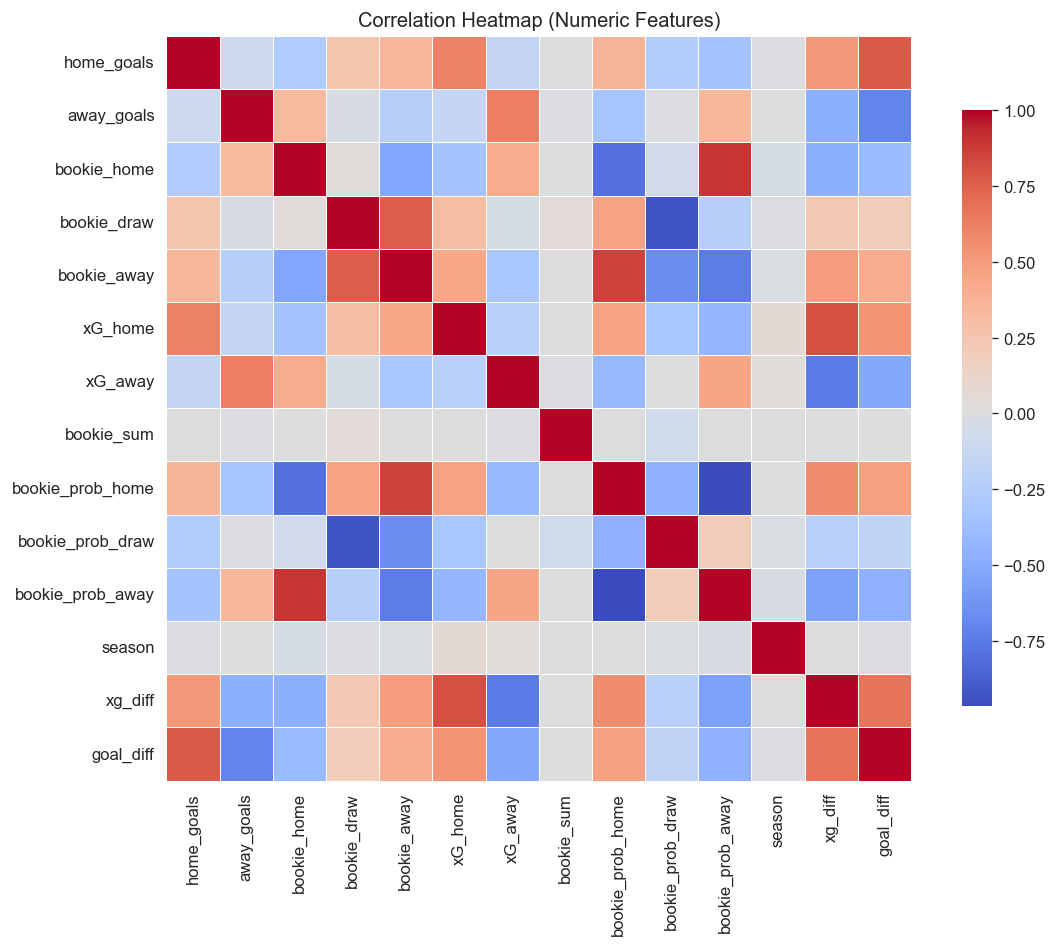

In [9]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols].corr(), cmap="coolwarm", square=True, linewidths=0.4, cbar_kws={"shrink":0.8})
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()

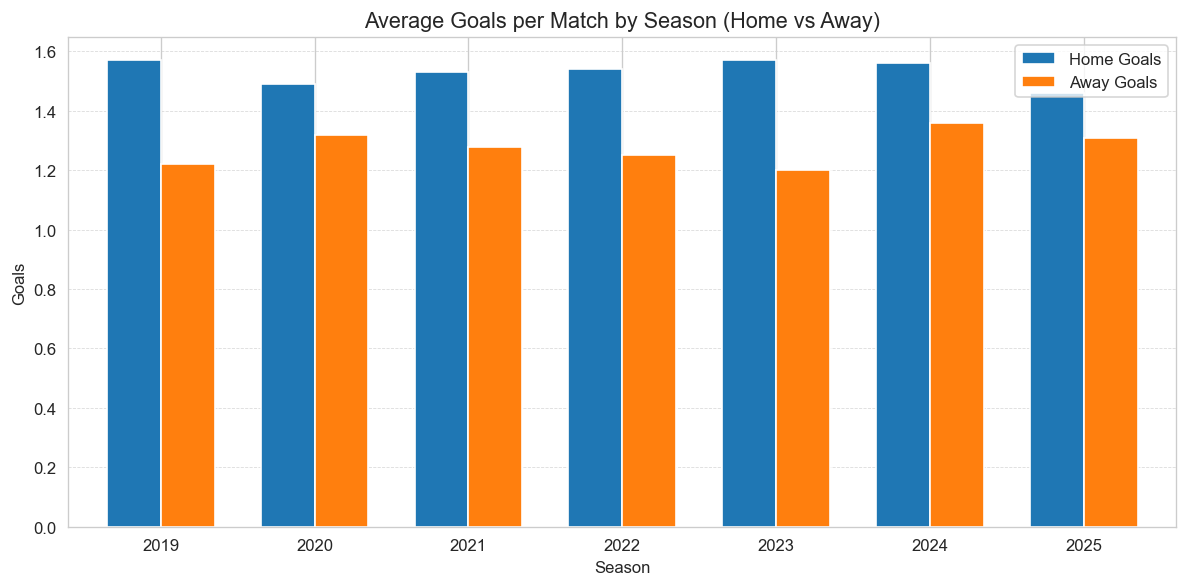

In [10]:
season_stats = (
    df.groupby("season")
      .agg(
          avg_goals_home=("home_goals", "mean"),
          avg_goals_away=("away_goals", "mean"),
          avg_xg_home=("xG_home", "mean"),
          avg_xg_away=("xG_away", "mean"),
      )
      .round(2)
      .reset_index()
)

fig, ax = plt.subplots(figsize=(10, 5))
season_stats.set_index("season")[["avg_goals_home", "avg_goals_away"]].plot(
    kind="bar",
    ax=ax,
    color=["#1f77b4", "#ff7f0e"],
    width=0.7,
)

ax.set_title("Average Goals per Match by Season (Home vs Away)", fontsize=13)
ax.set_ylabel("Goals")
ax.set_xlabel("Season")
ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)
ax.set_axisbelow(True)
ax.legend(["Home Goals", "Away Goals"])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


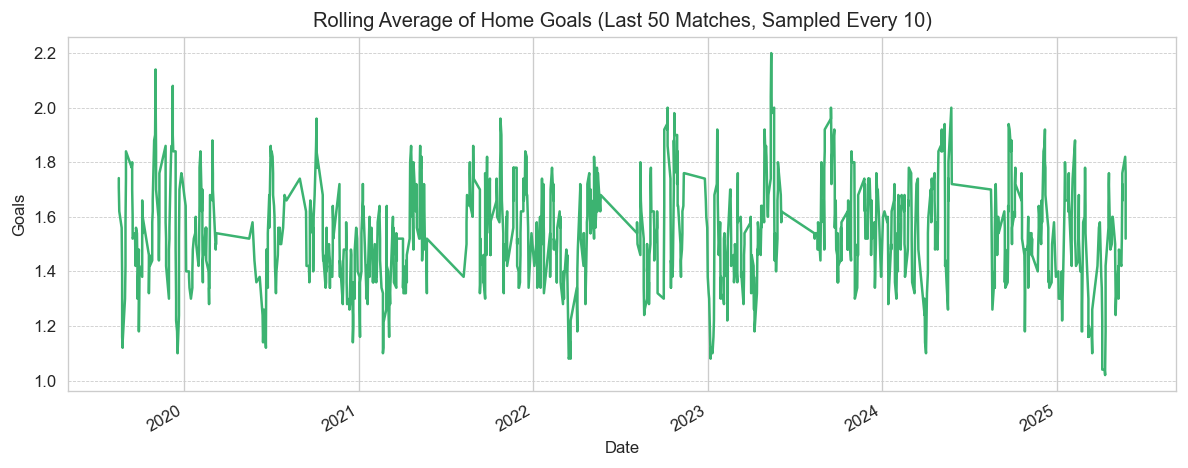

In [11]:
rolling_home = (
    df.sort_values("date")
      .set_index("date")
      .home_goals
      .rolling(window=50, min_periods=25)
      .mean()
      .iloc[::10]  
)

plt.figure(figsize=(10, 4))
rolling_home.plot(color="mediumseagreen")
plt.title("Rolling Average of Home Goals (Last 50 Matches, Sampled Every 10)")
plt.ylabel("Goals")
plt.xlabel("Date")
plt.grid(axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


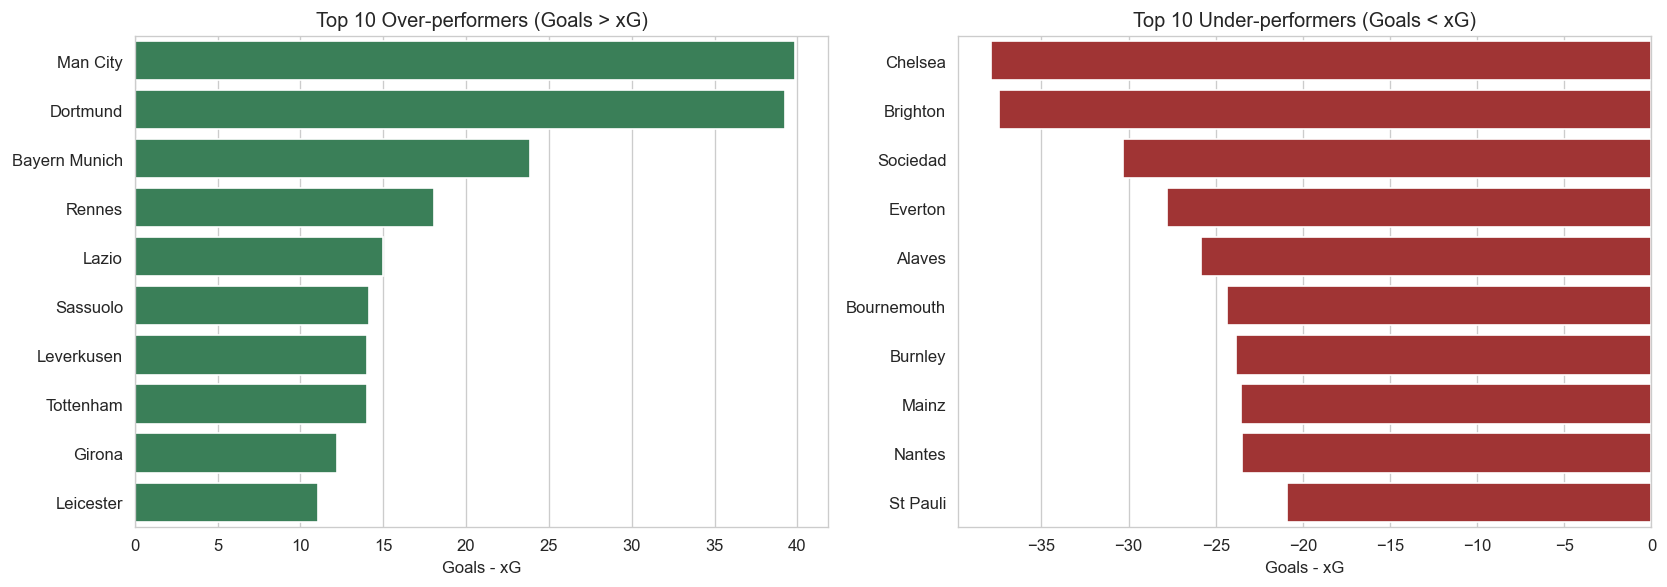

In [12]:
team_perf = (df.groupby("home_team")
    .agg(total_goals_home=("home_goals","sum"),
         total_xg_home=("xG_home","sum"))
    .reset_index())
team_perf["delta"] = team_perf["total_goals_home"] - team_perf["total_xg_home"]


top_over  = team_perf.nlargest(10, "delta")
top_under = team_perf.nsmallest(10, "delta")

fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.barplot(x="delta", y="home_team", data=top_over, ax=axes[0], color="seagreen")
axes[0].set_title("Top 10 Over-performers (Goals > xG)")
axes[0].set_xlabel("Goals - xG") 
axes[0].set_ylabel("")

sns.barplot(x="delta", y="home_team", data=top_under, ax=axes[1], color="firebrick")
axes[1].set_title("Top 10 Under-performers (Goals < xG)")
axes[1].set_xlabel("Goals - xG") 
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

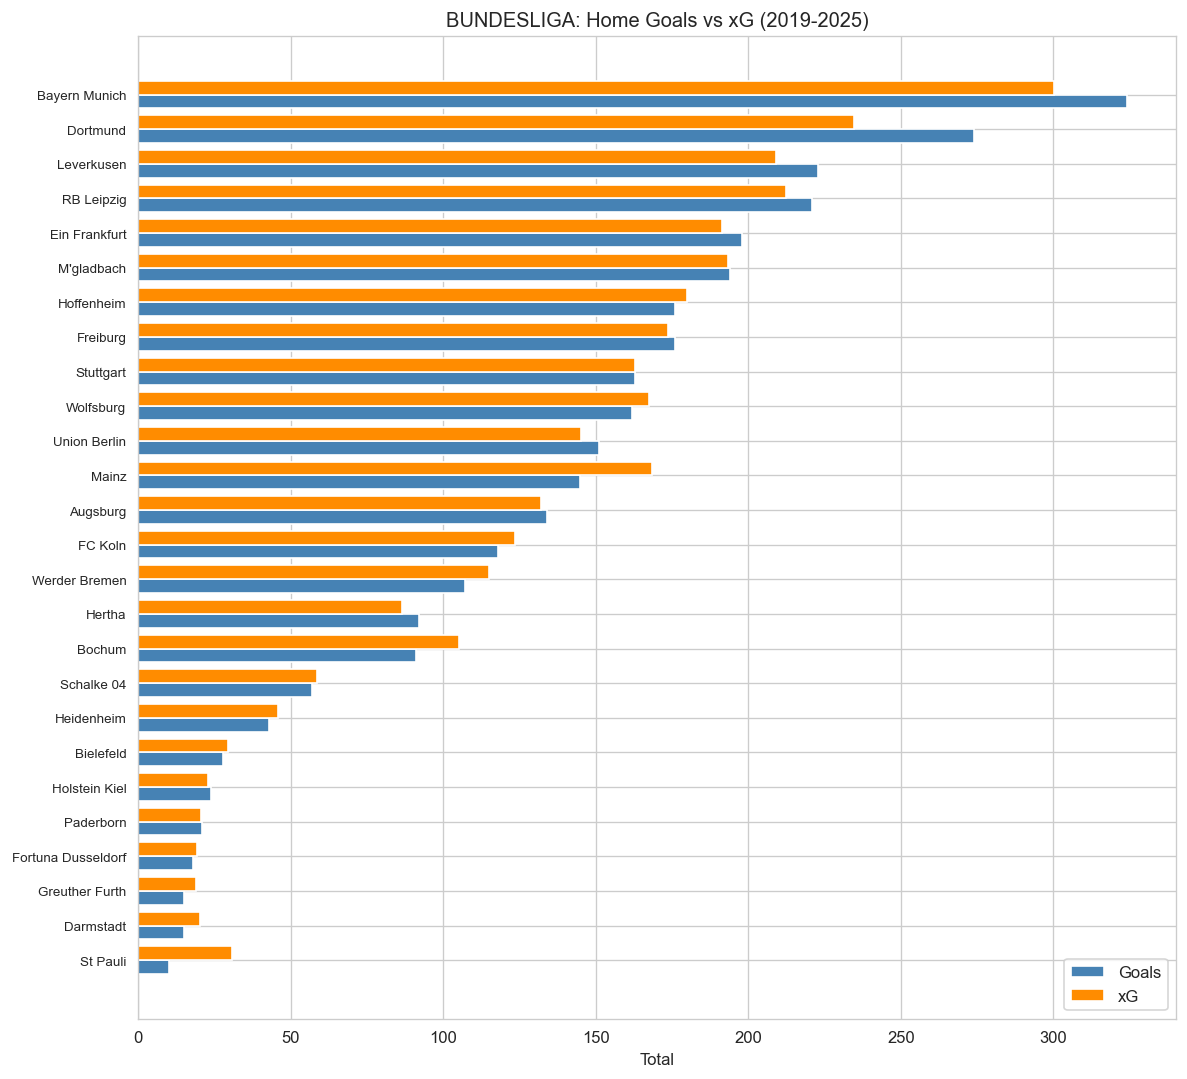

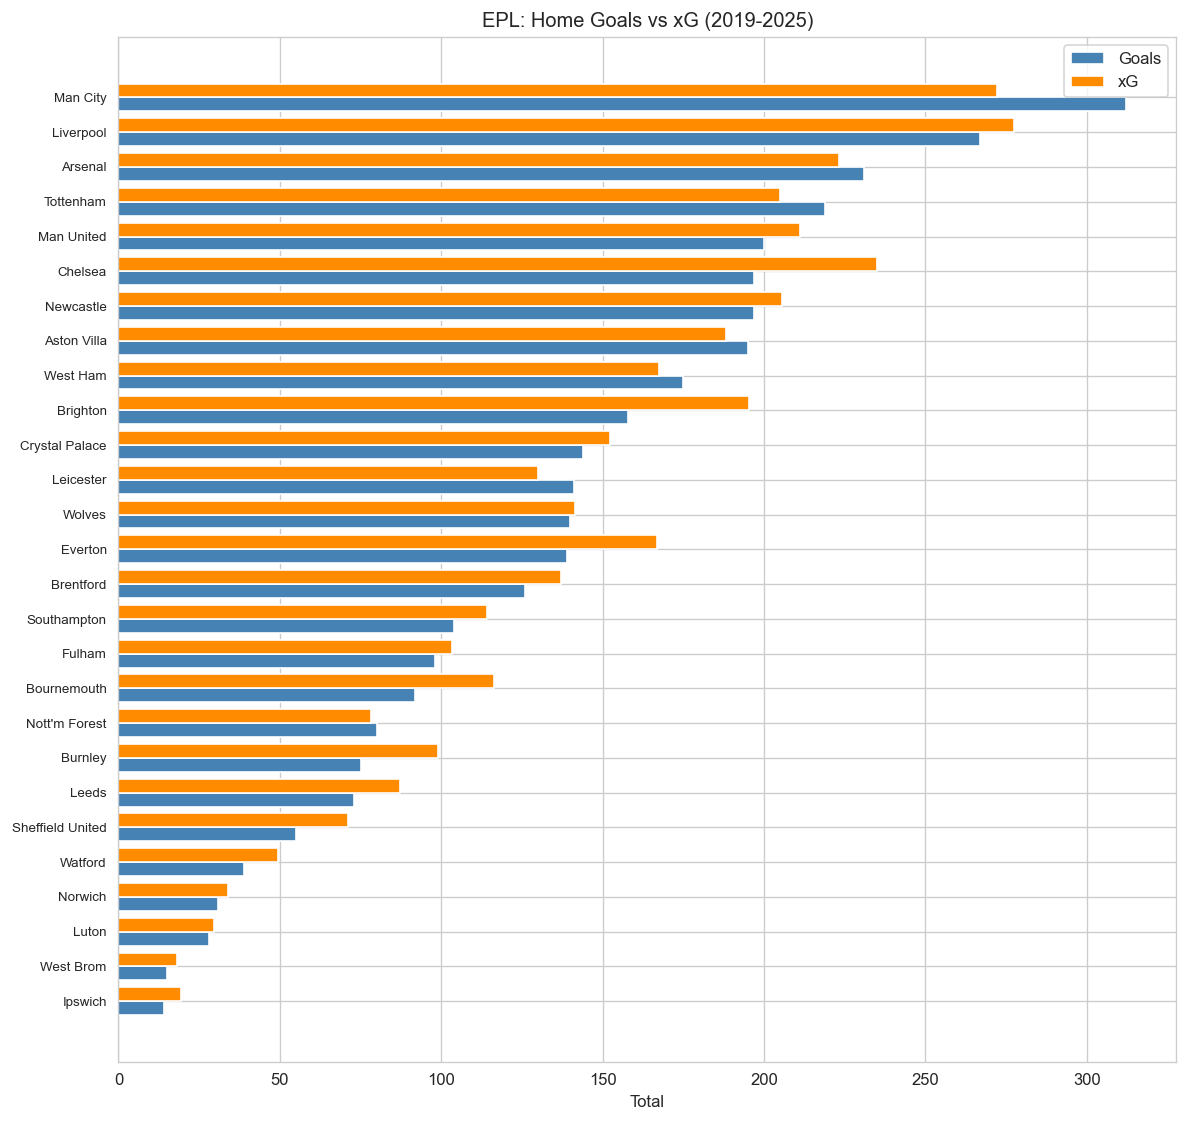

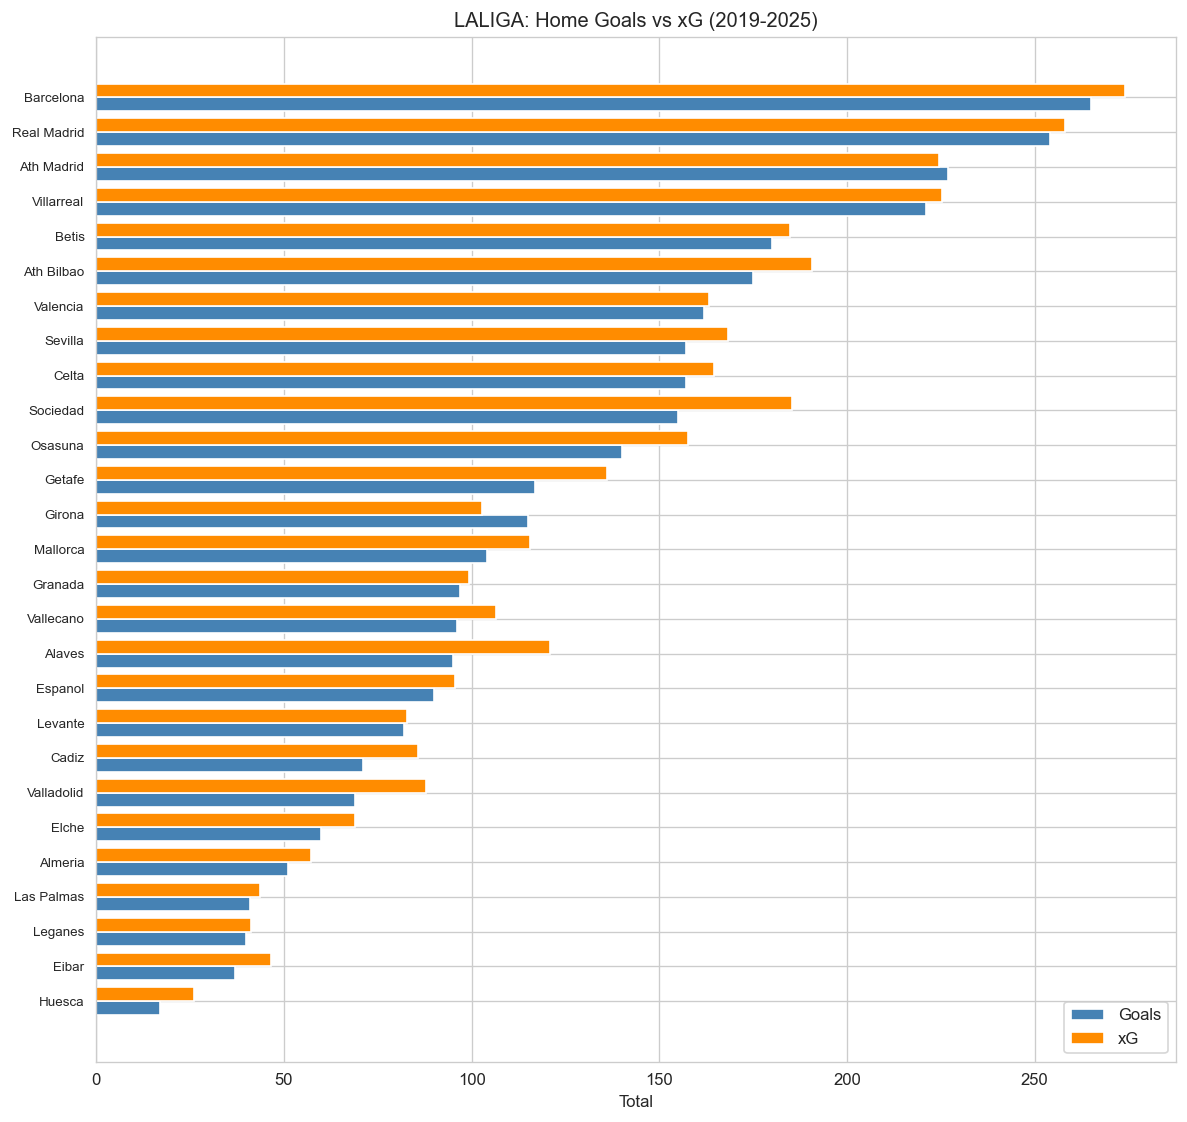

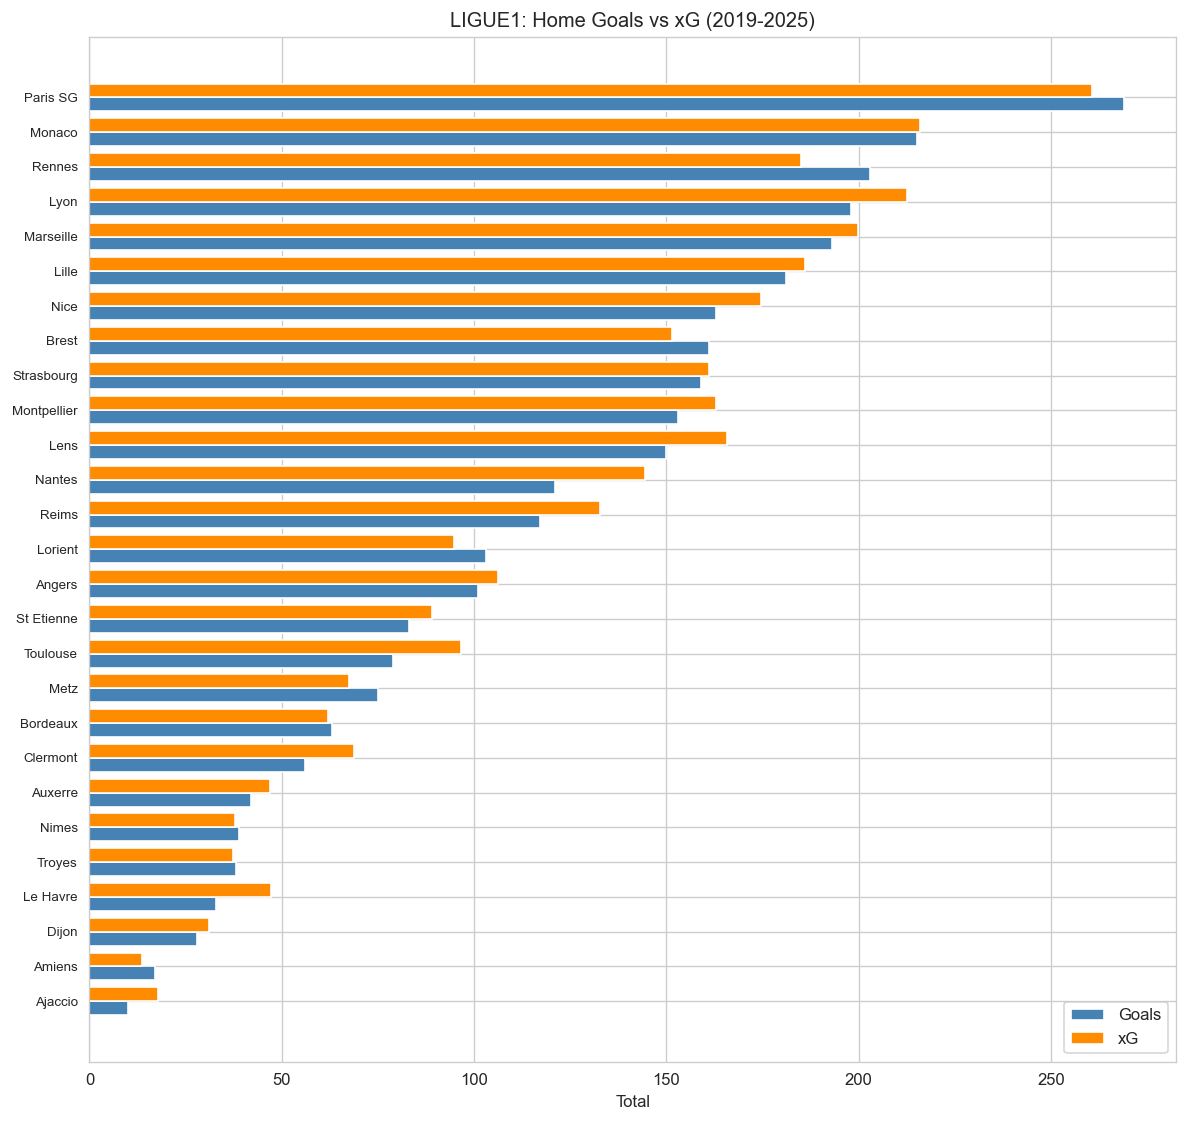

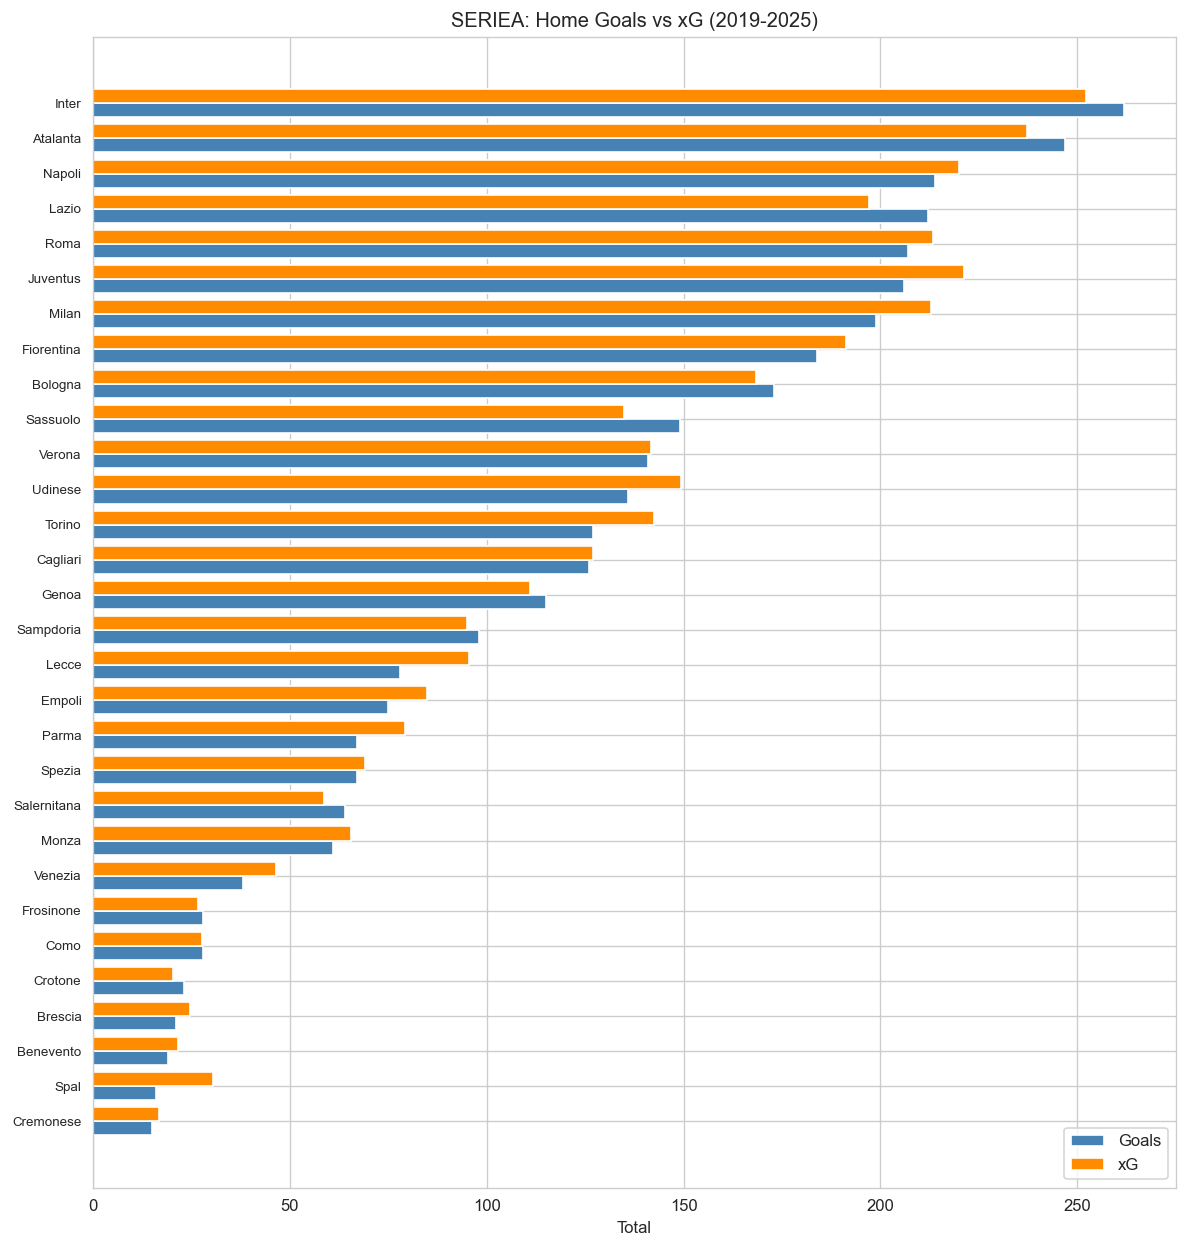

In [13]:
team_stats = (df.groupby(["home_team","league"])
    .agg(total_goals_home=("home_goals","sum"),
         total_xg_home=("xG_home","sum"))
    .reset_index())

for lg in sorted(team_stats["league"].unique()):
    sub = team_stats[team_stats["league"] == lg].sort_values("total_goals_home", ascending=True)
    y = np.arange(len(sub))
    plt.figure(figsize=(10, max(6, len(sub)*0.35)))
    plt.barh(y, sub["total_goals_home"], 0.4, label="Goals", color="steelblue")
    plt.barh(y + 0.4, sub["total_xg_home"], 0.4, label="xG", color="darkorange")
    plt.yticks(y + 0.2, sub["home_team"], fontsize=8)
    plt.xlabel("Total")
    plt.title(f"{lg}: Home Goals vs xG (2019-2025)")
    plt.legend()
    plt.tight_layout()
    plt.show()

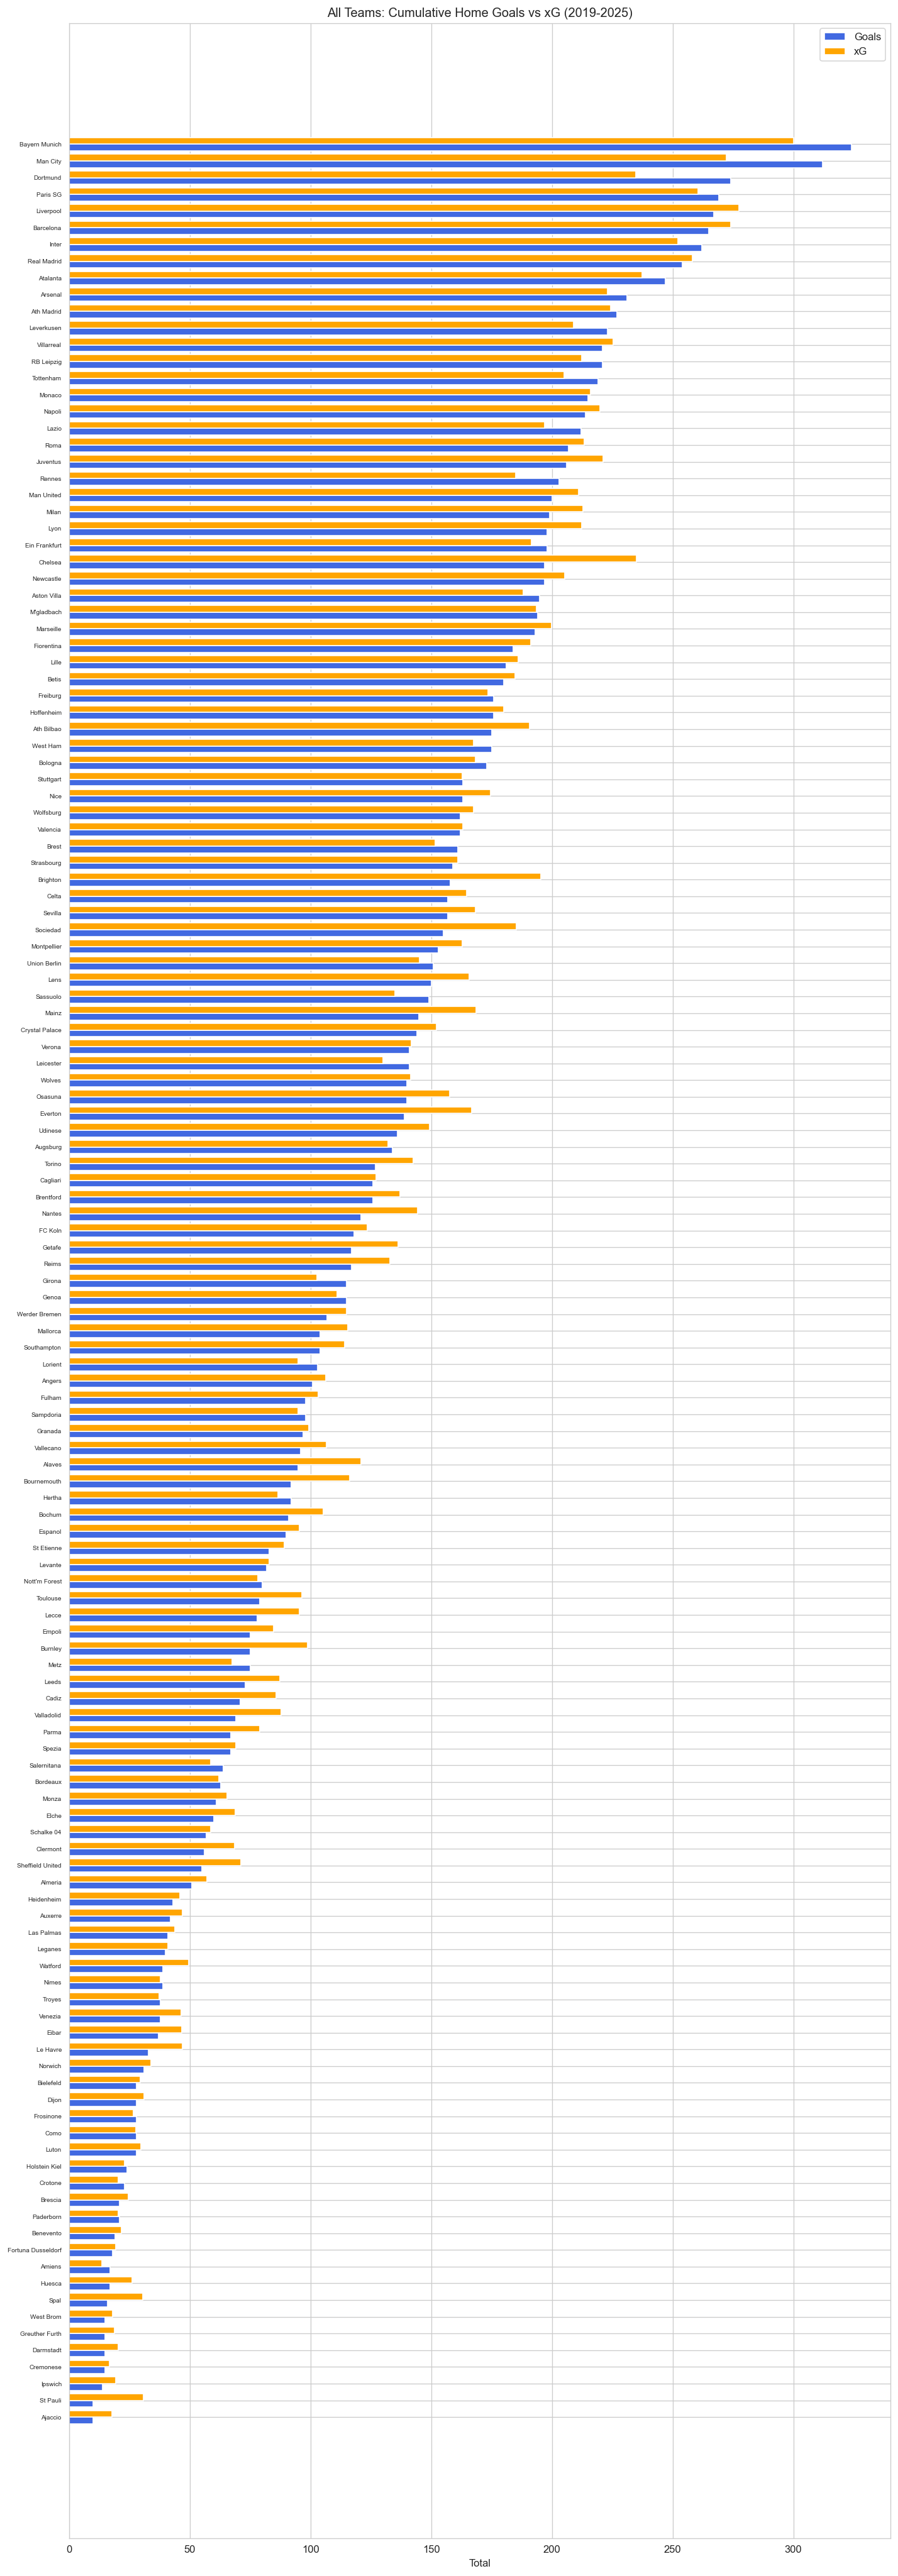

In [14]:
all_stats = (df.groupby("home_team")
    .agg(total_goals_home=("home_goals","sum"),
         total_xg_home=("xG_home","sum"))
    .sort_values("total_goals_home", ascending=True))

y = np.arange(len(all_stats))
plt.figure(figsize=(12, max(6, len(all_stats)*0.25)))
plt.barh(y, all_stats["total_goals_home"], 0.4, label="Goals", color="royalblue")
plt.barh(y + 0.4, all_stats["total_xg_home"], 0.4, label="xG", color="orange")
plt.yticks(y + 0.2, all_stats.index, fontsize=6)
plt.xlabel("Total")
plt.title("All Teams: Cumulative Home Goals vs xG (2019-2025)")
plt.legend()
plt.tight_layout()
plt.show()

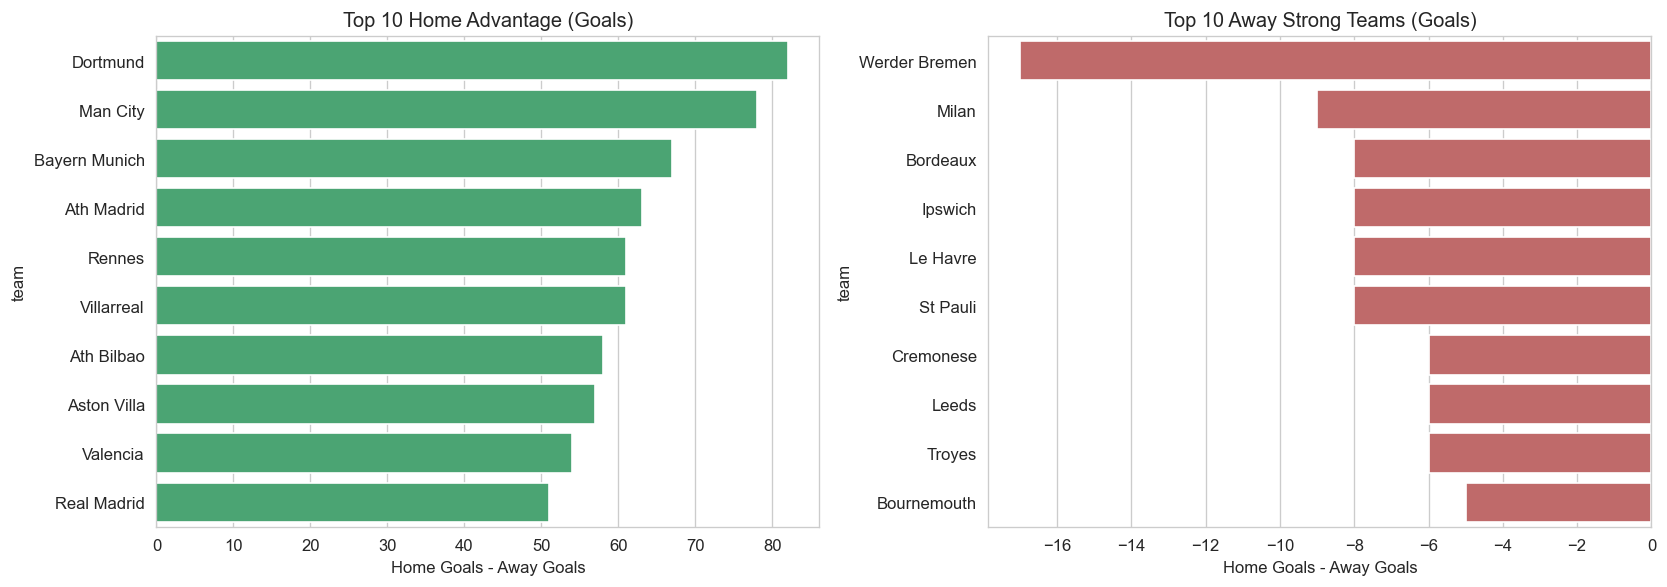

In [15]:
home_agg = df.groupby("home_team").agg(home_goals_sum=("home_goals","sum"), home_xg_sum=("xG_home","sum"))
away_agg = df.groupby("away_team").agg(away_goals_sum=("away_goals","sum"), away_xg_sum=("xG_away","sum"))

team_compare = (home_agg.reset_index().merge(
    away_agg.reset_index(),
    left_on="home_team", right_on="away_team", how="outer"
).fillna(0))

team_compare["team"] = team_compare["home_team"].combine_first(team_compare["away_team"])
team_compare["goal_diff_home_away"] = team_compare["home_goals_sum"] - team_compare["away_goals_sum"]
team_compare["xg_diff_home_away"] = team_compare["home_xg_sum"] - team_compare["away_xg_sum"]
team_compare = team_compare.set_index("team")

top_home_adv  = team_compare["goal_diff_home_away"].nlargest(10)
top_away_adv  = team_compare["goal_diff_home_away"].nsmallest(10)

fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.barplot(x=top_home_adv.values, y=top_home_adv.index, ax=axes[0], color="mediumseagreen")
axes[0].set_title("Top 10 Home Advantage (Goals)")
axes[0].set_xlabel("Home Goals - Away Goals")

sns.barplot(x=top_away_adv.values, y=top_away_adv.index, ax=axes[1], color="indianred")
axes[1].set_title("Top 10 Away Strong Teams (Goals)")
axes[1].set_xlabel("Home Goals - Away Goals")

plt.tight_layout()
plt.show()